# Get cell states vs storage for all ResOps reservoirs

In [1]:
import os
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import seaborn as sns
from scipy import stats
from scipy.stats import theilslopes
import geopandas as gpd
import os
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.data.implied_storage import get_implied_storage
from src.models.analyze_lstm_cell import *

## Compare Performance on ResOps
For manual unroll Model 1-4

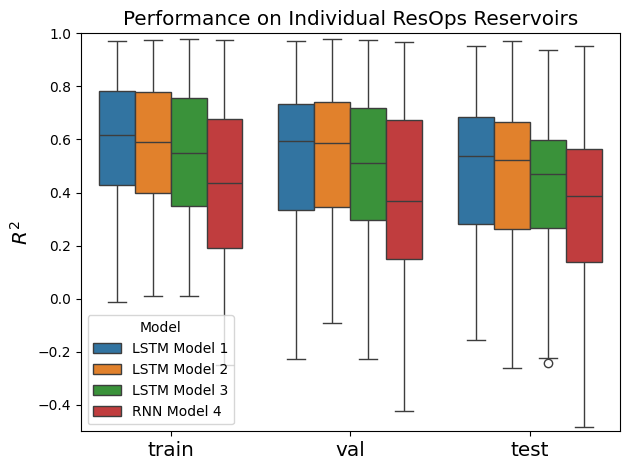

In [3]:
# Compare with benchmark scores
r2_scores_model1 = pd.read_csv('report/results/resops_training/resops_unroll_models/resops_unroll_model1_r2.csv', index_col=0)
r2_scores_model2 = pd.read_csv('report/results/resops_training/resops_unroll_models/resops_unroll_model2_r2.csv', index_col=0)
r2_scores_model3 = pd.read_csv('report/results/resops_training/resops_unroll_models/resops_unroll_model3_r2.csv', index_col=0)
r2_scores_model4 = pd.read_csv('report/results/resops_training/resops_unroll_models/resops_unroll_model4_r2.csv', index_col=0)

# Convert to long format
r2_scores_model1 = r2_scores_model1.melt(value_vars=['train', 'val', 'test'])
r2_scores_model2 = r2_scores_model2.melt(value_vars=['train', 'val', 'test'])
r2_scores_model3 = r2_scores_model3.melt(value_vars=['train', 'val', 'test'])
r2_scores_model4 = r2_scores_model4.melt(value_vars=['train', 'val', 'test'])

# Add model type
r2_scores_model1['Model'] = 'LSTM Model 1'
r2_scores_model2['Model'] = 'LSTM Model 2'
r2_scores_model3['Model'] = 'LSTM Model 3'
r2_scores_model4['Model'] = 'RNN Model 4'

# Concat and plot
r2_scores_unroll = pd.concat([r2_scores_model1, r2_scores_model2, r2_scores_model3, r2_scores_model4], axis=0)

fig, ax = plt.subplots()
bp = sns.boxplot(data=r2_scores_unroll, x='variable', y='value', hue='Model')
ax.set_title('Performance on Individual ResOps Reservoirs', size='x-large')
ax.set_ylabel('$R^2$', size='x-large')
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), size='x-large')
plt.ylim(-0.5, 1)
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/individual_lstm_unroll_resops.png', dpi=300)
plt.show()

C:\Users\mattc\AppData\Local\Temp\ipykernel_7604\3681994540.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


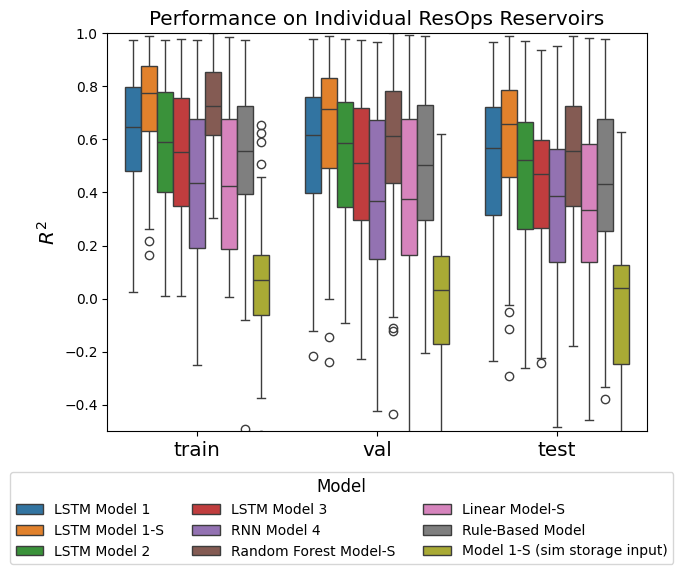

In [4]:
# Compare with benchmark scores
r2_scores_lstm = pd.read_csv('report/results/resops_training/resops_individual_r2.csv', index_col=0)
r2_scores_lstm_storage = pd.read_csv('report/results/resops_training/resops_benchmark_lstm_w_storage_r2.csv', index_col=0)
r2_scores_model2 = pd.read_csv('report/results/resops_training/resops_unroll_models/resops_unroll_model2_r2.csv', index_col=0)
r2_scores_model3 = pd.read_csv('report/results/resops_training/resops_unroll_models/resops_unroll_model3_r2.csv', index_col=0)
r2_scores_model4 = pd.read_csv('report/results/resops_training/resops_unroll_models/resops_unroll_model4_r2.csv', index_col=0)
r2_scores_linear = pd.read_csv('report/results/resops_training/resops_benchmark_linear_r2.csv', index_col=0)
r2_scores_rf = pd.read_csv('report/results/resops_training/resops_benchmark_rf_r2.csv', index_col=0)
r2_scores_rule_based = pd.read_csv('report/results/resops_training/resops_benchmark_rule_based_r2.csv', index_col=0)
r2_scores_1s_sim = pd.read_csv('report/results/resops_training/resops_model1s_sim_storage_r2.csv', index_col=0) # From implied input experiment 12

# Convert to long format
r2_scores_lstm = r2_scores_lstm.melt(value_vars=['train', 'val', 'test'])
r2_scores_lstm_storage = r2_scores_lstm_storage.melt(value_vars=['train', 'val', 'test'])
r2_scores_model2 = r2_scores_model2.melt(value_vars=['train', 'val', 'test'])
r2_scores_model3 = r2_scores_model3.melt(value_vars=['train', 'val', 'test'])
r2_scores_model4 = r2_scores_model4.melt(value_vars=['train', 'val', 'test'])
r2_scores_linear = r2_scores_linear.melt(value_vars=['train', 'val', 'test'])
r2_scores_rf = r2_scores_rf.melt(value_vars=['train', 'val', 'test'])
r2_scores_rule_based = r2_scores_rule_based.melt(value_vars=['train', 'val', 'test'])
r2_scores_1s_sim = r2_scores_1s_sim.melt(value_vars=['train', 'val', 'test'])


# Add model type
r2_scores_lstm['Model'] = 'LSTM Model 1'
r2_scores_lstm_storage['Model'] = 'LSTM Model 1-S'
r2_scores_model2['Model'] = 'LSTM Model 2'
r2_scores_model3['Model'] = 'LSTM Model 3'
r2_scores_model4['Model'] = 'RNN Model 4'
r2_scores_linear['Model'] = 'Linear Model-S'
r2_scores_rf['Model'] = 'Random Forest Model-S'
r2_scores_rule_based['Model'] = 'Rule-Based Model'
r2_scores_1s_sim['Model'] = 'Model 1-S (sim storage input)'


# Concat
r2_scores_benchmark = pd.concat([r2_scores_lstm, r2_scores_lstm_storage, r2_scores_model2, r2_scores_model3, r2_scores_model4, r2_scores_rf, r2_scores_linear, r2_scores_rule_based, r2_scores_1s_sim], axis=0)

fig, ax = plt.subplots(constrained_layout=True)
bp = sns.boxplot(data=r2_scores_benchmark, x='variable', y='value', hue='Model')
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()
# fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.4, 0.5), ncol=1, frameon=True, title='Model', fontsize='medium', title_fontsize='large')
legend = fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=True, title='Model', fontsize='medium', title_fontsize='large')
legend.set_in_layout(True)

ax.set_title('Performance on Individual ResOps Reservoirs', size='x-large')
ax.set_ylabel('$R^2$', size='x-large')
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), size='x-large')
plt.ylim(-0.5, 1)
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/individual_resops_all_benchmarks.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
r2_scores_benchmark.groupby(['Model', 'variable']).median()

value
Model                         variable          
LSTM Model 1                  test      0.566793
                              train     0.645785
                              val       0.618378
LSTM Model 1-S                test      0.658247
                              train     0.775444
                              val       0.712742
LSTM Model 2                  test      0.520748
                              train     0.591598
                              val       0.586588
LSTM Model 3                  test      0.468586
                              train     0.550673
                              val       0.510923
Linear Model-S                test      0.332787
                              train     0.423572
                              val       0.375588
Model 1-S (sim storage input) test      0.038918
                              train     0.068473
                              val       0.033643
RNN Model 4                   test      0.388154
                              train     0.436426
                              val       0.368019
Random Forest Model-S         test      0.555316
                              train     0.726267
                              val       0.612221
Rule-Based Model              test      0.433223
                              train     0.555999
                              val       0.504121

## Get storage correlations

In [6]:
def data_processing(id, transform_type, left, right=None, train_frac=0.6, val_frac=0.2, test_frac=0.2, return_scaler=False, storage=False):
    """
    Run data processing pipeline for one ResOPS/USBR reservoir.
    Params:
    id -- str, ResOPS reservoir ID (numeric) or USBR name (character)
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window. By default, '2020-12-31' for ResOPS and '2022-12-31' for USBR
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    storage -- bool, whether or not to include storage data in features
    """

    # Read in data, columns are [inflow, outflow, storage]
    if id.isdigit():
        df = resops_fetch_data(res_id=id, vars=['inflow', 'outflow', 'storage'])
        right = '2020-12-31' if right is None else right # Default right window for ResOPS
    else:
        df = usbr_fetch_data(name=id, vars=['inflow', 'outflow', 'storage'])
        right = '2022-12-31' if right is None else right # Default right window for USBR

    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    if storage:
        X_train, X_val, X_test = ts_train[:, :, [0, 2, 3]], ts_val[:, :, [0, 2, 3]], ts_test[:, :, [0, 2, 3]]
    else:
        X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)



def load_resops_model(res_id, model_num=1, path=None):
    """ 
    Load trained manual unroll LSTM (Model 1-4) for one ResOPS reservoir
    Params:
    res_id -- int, ResOPS reservoir ID
    model_num -- int, which manual unroll model to load (1-4)
    path -- default None (load weights from unroll ResOPS model), if provided, ignore res_id input and load model directly from provided path. If 'initialize', return initialized model.
    """
    input_size = 2 # inflow, doy

    if model_num == 1: # Model 1 (manual unroll)
        hidden_size1 = 30
        hidden_size2 = 15
        output_size = 1 # outflow
        dropout_prob = 0.3
        num_layers = 1

        torch.manual_seed(0)
        model = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                                    hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
    
    elif model_num == 2:
        hidden_size1 = 35
        hidden_size2 = 20
        num_layers = 1
        output_size = 1
        dropout_prob = 0.3

        torch.manual_seed(0)
        model = LSTMModel2(input_size=input_size, hidden_size1=hidden_size1, 
                                    hidden_size2=hidden_size2, num_layers=num_layers, output_size=output_size, dropout_prob=dropout_prob, initial_output=0)
    
    elif model_num == 3:
        hidden_size1 = 35
        hidden_size2 = 15
        num_layers = 1
        output_size = 1
        dropout_prob = 0.3

        torch.manual_seed(0)
        model = LSTMModel3(input_size=input_size, hidden_size1=hidden_size1, 
                                    hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob, initial_output=0, initial_implied_storage=0)
    
    elif model_num == 4:
        hidden_size = 50
        output_size = 1
        dropout_prob = 0.7
        torch.manual_seed(0)
        model = resRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                    dropout_prob=dropout_prob)
    
    # Load model weights
    if path is None:
        model.load_state_dict(torch.load(f'src/models/saved_models/resops_unroll_models/resops_model{model_num}_{res_id}.pt', weights_only=True))
    elif path == 'initialize':
        pass
    else:
        model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    return model

def correlate_cell_storage(id, model, left_year, return_data=False, add_linear_probe=True):
    """
    Get train/val/test cell state vs observed storage correlations
    Params:
    id - str, ResOPS reservoir ID (numeric) or USBR name (character)
    left_year - left and year window for data processing, i.e. for ResOPS from get_left_years(res_list)[res_id].
    return_data - also return train/val/test split df, cell states, and data tensors (default False)
    add_linear_probe - whether or not to train a linear probe and return the correlation of the probe to observed storage (default True)
    Returns:
    df of cell state - storage correlations for train/val/test data (each of (hidden_size, 3))
    """
    # Get split df data (fill NA with training mean)
    df_train, df_val, df_test = split_df_data(id=id, left=f'{left_year}-01-01', data_splits=(0.6, 0.2, 0.2), fill_train_mean=True)
    # Data processing
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = data_processing(id=id, transform_type='standardize',
                                                        left=f'{left_year}-01-01', return_scaler=False, storage=False)

    # Get hidden and cell states, result is list with one tensor for each layer, shape is (# chunks, timesteps, hidden size)
    with torch.no_grad():
        hidden_train, cell_train = model(X_train)[1]
        hidden_val, cell_val = model(X_val)[1]
        hidden_test, cell_test = model(X_test)[1]

    # Calculate correlations for layer 1
    correlation_data = {'train':cell_correlations(cell_states=cell_train[0], storage_states=df_train.storage.values),
                        'val': cell_correlations(cell_states=cell_val[0], storage_states=df_val.storage.values),
                        'test': cell_correlations(cell_states=cell_test[0], storage_states=df_test.storage.values)}
    df_corr = pd.DataFrame(correlation_data)

    # Add linear probe correlation (optional)
    if add_linear_probe:
        probe = cell_linear_probe()
        probe.fit_probe(cell_train[0], df_train.storage.values)
        df_corr.loc['linear_probe', :] = [probe.correlate_prediction(cell_train[0], df_train.storage.values), 
                                          probe.correlate_prediction(cell_val[0], df_val.storage.values), 
                                          probe.correlate_prediction(cell_test[0], df_test.storage.values)]
    
    if return_data:
        return df_corr, {'df_splits': (df_train, df_val, df_test), 'cell_splits': (cell_train, cell_val, cell_test), 'tensor_splits': (X_train, X_val, X_test, y_train, y_val, y_test)}
    else:
        return df_corr
    
def implied_storage_rmse(id, model, left_year, conv_factor):
    """ 
    Per timestep RMSE of implied change in storage (inflow - model outflow) vs change in observed storage
    Params:
    id - str, ResOPS reservoir ID (numeric) or USBR name (character)
    left_year - left and year window for data processing, i.e. for ResOPS from get_left_years(res_list)[res_id].
    conv_factor - convert (unscaled) inflow units to (unscaled) storage units
    Returns:
    tuple of (train, val, test) MSE of implied storage change vs observed storage using model outflow
    tuple of (train, val, test) MSE of implied storage change vs observed storage using observed outflow
    """
    # Get split df data (fill NA with training mean)
    df_train, df_val, df_test = split_df_data(id=id, left=f'{left_year}-01-01', data_splits=(0.6, 0.2, 0.2), fill_train_mean=True)
    # Data processing
    (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = data_processing(id=id, transform_type='standardize',
                                                        left=f'{left_year}-01-01', return_scaler=True, storage=False)

    # Get predicted outflow
    y_hat_train, y_hat_val, y_hat_test = predict(model, X_train), predict(model, X_val), predict(model, X_test)
    (y_hat_train, y_train), (y_hat_val, y_val), (y_hat_test, y_test) = flatten_rm_pad(y_hat_train, y_train), flatten_rm_pad(y_hat_val, y_val), flatten_rm_pad(y_hat_test, y_test) # remove padding and flatten
    y_hat_train, y_train, y_hat_val, y_val, y_hat_test, y_test = [arr * scaler.std[0, 1] + scaler.mean[0, 1] for arr in [y_hat_train, y_train, y_hat_val, y_val, y_hat_test, y_test]] # unscale
    assert len(df_train) == len(y_hat_train) and len(df_val) == len(y_hat_val) and len(df_test) == len(y_hat_test)

    # Implied storage delta
    delta_implied_train = conv_factor * (y_hat_train.numpy() - df_train.inflow.values)
    delta_implied_val = conv_factor * (y_hat_val.numpy() - df_val.inflow.values)
    delta_implied_test = conv_factor * (y_hat_test.numpy() - df_test.inflow.values)

    delta_implied_train_data = conv_factor * (df_train.inflow.values - df_train.outflow.values)
    delta_implied_val_data = conv_factor * (df_val.inflow.values - df_val.outflow.values)
    delta_implied_test_data = conv_factor * (df_test.inflow.values - df_test.outflow.values)

    # Observed storage delta
    delta_storage_train, delta_storage_val, delta_storage_test = np.diff(df_train.storage.values), np.diff(df_val.storage.values), np.diff(df_test.storage.values)

    # Calculate MSE (per timestep delta implied storage vs. delta storage)
    rmse_train = np.sqrt(((delta_implied_train[:-1] - delta_storage_train) ** 2).mean())
    rmse_val = np.sqrt(((delta_implied_val[:-1] - delta_storage_val) ** 2).mean())
    rmse_test = np.sqrt(((delta_implied_test[:-1] - delta_storage_test) ** 2).mean())
    rmse_data_train = np.sqrt(((delta_implied_train_data[:-1] - delta_storage_train) ** 2).mean())
    rmse_data_val = np.sqrt(((delta_implied_val_data[:-1] - delta_storage_val) ** 2).mean())
    rmse_data_test = np.sqrt(((delta_implied_test_data[:-1] - delta_storage_test) ** 2).mean())
    
    return (rmse_train, rmse_val, rmse_test), (rmse_data_train, rmse_data_val, rmse_data_test)

### Add Shasta (ID 132) / Folsom (ID 182) / New Melones (ID 198) / Trinity (131) from USBR

In [7]:
# Shasta
model_shasta = load_resops_model(res_id=None, model_num=1, path='src/models/saved_models/model1a.pt') # Since path is provided res_id is ignored
corr_sha, data_sha = correlate_cell_storage(id='Shasta', model=model_shasta, left_year='1944', return_data=True, add_linear_probe=True)
_, _, test_r2_sha = eval_train_val_test(model_shasta, *data_sha['tensor_splits'])
test_r2_sha

0.43345769288348546

In [8]:
# Folsom
(X_train_fol, y_train_fol), (X_val_fol, y_val_fol), (X_test_fol, y_test_fol), scaler_fol = data_processing(id='Folsom', transform_type='standardize', left=f'1963-01-01', right='2022-12-31',
                                                                                                return_scaler=True, storage=False)
dataset_train_fol, dataset_val_fol = (TensorDataset(X_train_fol, y_train_fol), TensorDataset(X_val_fol, y_val_fol))
dataloader_train_fol, dataloader_val_fol = (DataLoader(dataset_train_fol, batch_size=32, shuffle=False), 
                                                DataLoader(dataset_val_fol, batch_size=32, shuffle=False))

torch.manual_seed(0)
model_folsom = load_resops_model(res_id=None, model_num=1, path='initialize')
criterion = nn.MSELoss()
optimizer = optim.Adam(model_folsom.parameters(), lr=0.001)
train_losses_fol, val_losses_fol = training_loop(model=model_folsom, criterion=criterion, optimizer=optimizer, 
                                            patience=10, dataloader_train=dataloader_train_fol, 
                                            dataloader_val=dataloader_val_fol, epochs=1000)
corr_fol, data_fol = correlate_cell_storage(id='Folsom', model=model_folsom, left_year=1963, return_data=True)
_, _, test_r2_fol = eval_train_val_test(model=model_folsom, X_train=X_train_fol, X_val=X_val_fol, X_test=X_test_fol, y_train=y_train_fol, y_val=y_val_fol, y_test=y_test_fol)
test_r2_fol

Training epochs:  20%|██        | 205/1000 [00:49<03:13,  4.10it/s]


0.7968007085062111

In [9]:
# New Melones
(X_train_nm, y_train_nm), (X_val_nm, y_val_nm), (X_test_nm, y_test_nm), scaler_nm = data_processing(id='New_Melones', transform_type='standardize', left=f'1980-01-01', right='2022-12-31',
                                                                                                return_scaler=True, storage=False)
dataset_train_nm, dataset_val_nm = (TensorDataset(X_train_nm, y_train_nm), TensorDataset(X_val_nm, y_val_nm))
dataloader_train_nm, dataloader_val_nm = (DataLoader(dataset_train_nm, batch_size=32, shuffle=False), 
                                                DataLoader(dataset_val_nm, batch_size=32, shuffle=False))

torch.manual_seed(0)
model_nm = load_resops_model(res_id=None, model_num=1, path='initialize')
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nm.parameters(), lr=0.001)
train_losses_nm, val_losses_nm = training_loop(model=model_nm, criterion=criterion, optimizer=optimizer, 
                                            patience=10, dataloader_train=dataloader_train_nm, 
                                            dataloader_val=dataloader_val_nm, epochs=1000)
corr_nm, data_nm = correlate_cell_storage(id='New_Melones', model=model_nm, left_year=1980, return_data=True)
_, _, test_r2_nm = eval_train_val_test(model=model_nm, X_train=X_train_nm, X_val=X_val_nm, X_test=X_test_nm, y_train=y_train_nm, y_val=y_val_nm, y_test=y_test_nm)
test_r2_nm

Training epochs:  12%|█▏        | 123/1000 [00:32<03:52,  3.77it/s]


0.4226440399577337

In [10]:
# Trinity
(X_train_tri, y_train_tri), (X_val_tri, y_val_tri), (X_test_tri, y_test_tri), scaler_tri = data_processing(id='Trinity', transform_type='standardize', left=f'1963-01-01', right='2022-12-31',
                                                                                                return_scaler=True, storage=False)
dataset_train_tri, dataset_val_tri = (TensorDataset(X_train_tri, y_train_tri), TensorDataset(X_val_tri, y_val_tri))
dataloader_train_tri, dataloader_val_tri = (DataLoader(dataset_train_tri, batch_size=32, shuffle=False), 
                                                DataLoader(dataset_val_tri, batch_size=32, shuffle=False))

torch.manual_seed(0)
model_tri = load_resops_model(res_id=None, model_num=1, path='initialize')
criterion = nn.MSELoss()
optimizer = optim.Adam(model_tri.parameters(), lr=0.001)
train_losses_tri, val_losses_tri = training_loop(model=model_tri, criterion=criterion, optimizer=optimizer, 
                                            patience=10, dataloader_train=dataloader_train_tri, 
                                            dataloader_val=dataloader_val_tri, epochs=1000)
corr_tri, data_tri = correlate_cell_storage(id='Trinity', model=model_tri, left_year=1963, return_data=True)
_, _, test_r2_tri = eval_train_val_test(model=model_tri, X_train=X_train_tri, X_val=X_val_tri, X_test=X_test_tri, y_train=y_train_tri, y_val=y_val_tri, y_test=y_test_tri)
test_r2_tri

Training epochs:   7%|▋         | 71/1000 [00:20<04:21,  3.55it/s]


0.12428718695589525

### Correlate cell-storages in test set for all reservoirs

In [11]:
def correlate_cell_storage_all():
    """ 
    For Model 1 and Model 2, for each ResOPS reservoir, correlate each LSTM cell state with observed storage in train/val/test sets. Save all results as csv.
    """
    # Get list of reservoirs and left data years
    res_list = filter_res()
    left_years_dict = get_left_years(res_list=res_list)

    model_num_list = [1, 2]
    for model_num in model_num_list:
        # Initialize empty dataframes to store correlation results
        df_corr_train = pd.DataFrame(columns=res_list)
        df_corr_val = pd.DataFrame(columns=res_list)
        df_corr_test = pd.DataFrame(columns=res_list)

        for res in tqdm(res_list, desc=f'Processing reservoirs for model {model_num}'):
            # Load trained model (ResOPS unroll)
            model = load_resops_model(res_id=res, model_num=model_num)
            
            # Calculate cell correlations and save to df
            res_corr = correlate_cell_storage(id=res, model=model, left_year=left_years_dict[res], return_data=False)
            df_corr_train.loc[:, res] = res_corr['train'].values
            df_corr_val.loc[:, res] = res_corr['val'].values
            df_corr_test.loc[:, res] = res_corr['test'].values
        
        if model_num == 1:
            # Add Shasta from USBR (ID 132) for Model 1
            df_corr_train.loc[:, '132'], df_corr_val.loc[:, '132'], df_corr_test.loc[:, '132'] = corr_sha['train'].values, corr_sha['val'].values, corr_sha['test'].values
            # Add Folsom from USBR (ID 182) for Model 1 (model trained above)
            df_corr_train.loc[:, '182'], df_corr_val.loc[:, '182'], df_corr_test.loc[:, '182'] = corr_fol['train'].values, corr_fol['val'].values, corr_fol['test'].values
            # Add New Melones from USBR (ID 198) for Model 1 (model trained above)
            df_corr_train.loc[:, '198'], df_corr_val.loc[:, '198'], df_corr_test.loc[:, '198'] = corr_nm['train'].values, corr_nm['val'].values, corr_nm['test'].values
            # Add Trinity from USBR (ID 131) for Model 1 (model trained above)
            df_corr_train.loc[:, '131'], df_corr_val.loc[:, '131'], df_corr_test.loc[:, '131'] = corr_tri['train'].values, corr_tri['val'].values, corr_tri['test'].values

        # Save results as csv
        df_corr_train.to_csv(f'report/results/resops_training/resops_unroll_models/cell_storage_correlations/cell_storage_corr_model{model_num}_train.csv')
        df_corr_val.to_csv(f'report/results/resops_training/resops_unroll_models/cell_storage_correlations/cell_storage_corr_model{model_num}_val.csv')
        df_corr_test.to_csv(f'report/results/resops_training/resops_unroll_models/cell_storage_correlations/cell_storage_corr_model{model_num}_test.csv')
    return

In [12]:
# Commented out since already run
# correlate_cell_storage_all()

In [13]:
df_corr_test_model1 = pd.read_csv('report/results/resops_training/resops_unroll_models/cell_storage_correlations/cell_storage_corr_model1_test.csv', index_col=0)
df_corr_test_model2 = pd.read_csv('report/results/resops_training/resops_unroll_models/cell_storage_correlations/cell_storage_corr_model2_test.csv', index_col=0)

# Maximum absolute correlations on test data (for model 1, last index is for linear probe)
df_corr_max_test = pd.DataFrame({'model1_max_cell_sto_corr': df_corr_test_model1.iloc[:-1, :].abs().max(axis=0), 'model2_max_cell_sto_corr': df_corr_test_model2.abs().max(axis=0)})

# Correlations of linear probe for model 1 on test data
df_corr_probe_test = pd.DataFrame({'model1_linear_probe_corr': df_corr_test_model1.iloc[-1, :].abs()})

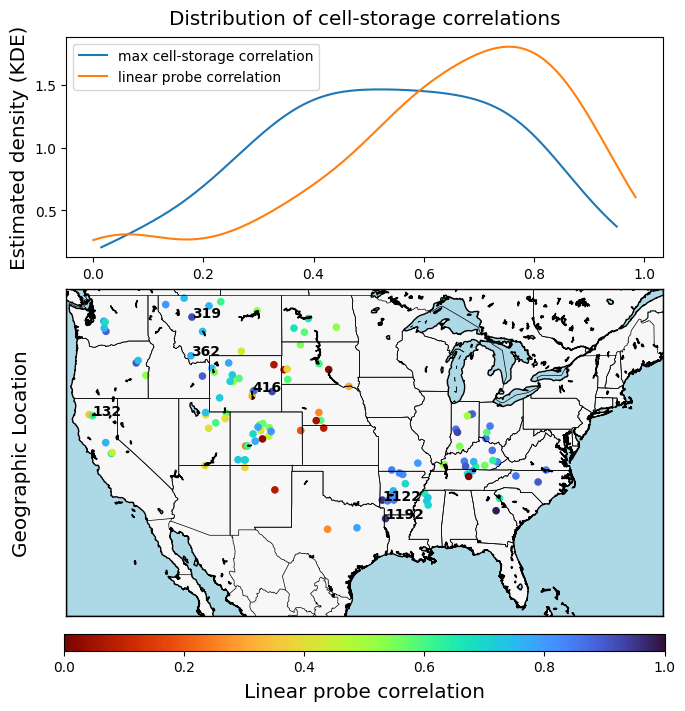

In [14]:
# Fetch GPS coordinates of reservoirs
coords_all = pd.read_csv('data/ResOpsUS/attributes/reservoir_attributes.csv', index_col=0)[['LONG', 'LAT']]
coords_all.index = coords_all.index.astype(str)
df_corr_coords = df_corr_probe_test.join(other=coords_all, how='left')
df_corr_coords = df_corr_coords.join(other=df_corr_max_test, how='left')

# Plot KDE (max cell-storage correlation on test)
fig, axes = plt.subplots(nrows=2, figsize=(9, 7), constrained_layout=True, gridspec_kw={'height_ratios': [1, 1.48]})
kde_max = stats.gaussian_kde(df_corr_max_test['model1_max_cell_sto_corr'])
x_kde_max = np.linspace(min(df_corr_max_test['model1_max_cell_sto_corr']), max(df_corr_max_test['model1_max_cell_sto_corr']), 400)
axes[0].set_box_aspect(0.37)
axes[0].plot(x_kde_max, kde_max(x_kde_max), label='max cell-storage correlation')
axes[0].set_ylabel("Estimated density (KDE)", size='x-large')

# Plot KDE (linear probe correlation on test)
kde_probe = stats.gaussian_kde(df_corr_probe_test['model1_linear_probe_corr'])
x_kde_probe = np.linspace(min(df_corr_probe_test['model1_linear_probe_corr']), max(df_corr_probe_test['model1_linear_probe_corr']), 400)
axes[0].plot(x_kde_probe, kde_probe(x_kde_probe), label='linear probe correlation')
axes[0].legend()

# Plot map of linear probe correlations (test data)
map = Basemap(projection='merc', llcrnrlat=24.396308, urcrnrlat=49.384358,
              llcrnrlon=-125.001650, urcrnrlon=-66.934570, resolution='i', ax=axes[1])
map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.fillcontinents(color='#f7f7f7', lake_color='lightblue')
map.drawmapboundary(fill_color='lightblue')
# Convert lat/long to map projection coordinates
x, y = map(df_corr_coords['LONG'], df_corr_coords['LAT'])
# Scatter plot with color coding
sc = map.scatter(x, y, c=df_corr_coords['model1_linear_probe_corr'], 
                 vmin=0, vmax=1, cmap='turbo_r', s=20, ax=axes[1])
# Add ID labels
label_ids = ['132', '416', '1192', '1122', '319', '362']
for label in label_ids:
    x_label, y_label = map(df_corr_coords.loc[label, 'LONG'], df_corr_coords.loc[label, 'LAT'])
    axes[1].text(x_label, y_label, label, fontsize=10, weight='bold')
axes[1].set_ylabel("Geographic Location", size='x-large', labelpad=25)

# Add a colorbar
cbar = plt.colorbar(sc, ax=[axes[1]], orientation='horizontal', shrink=0.673, aspect=35)

fig.supxlabel("Linear probe correlation", size='x-large')
fig.suptitle("Distribution of cell-storage correlations", size='x-large')
plt.savefig('report/drafting/8_15_2025/Figures/max_cell_storage_corr_distribution.png', dpi=300)
plt.show()

In [15]:
df_corr_coords.describe()

,model1_linear_probe_corr,LONG,LAT,model1_max_cell_sto_corr,model2_max_cell_sto_corr
count,119.000000,119.000000,119.000000,119.000000,116.000000
mean,0.628430,-101.104371,40.221505,0.527449,0.659189
std,0.237280,11.748312,4.226961,0.222041,0.220045
min,0.000446,-122.760687,31.834514,0.014753,0.017681
25%,0.525432,-109.303645,36.985146,0.369090,0.541624
50%,0.672788,-103.786348,39.805524,0.524423,0.710732
75%,0.810868,-90.013632,43.610359,0.700685,0.818628
max,0.984379,-78.294784,48.828116,0.950158,0.983093


## Relationships storage-outflow correlation, DOR, or model performance?

In [16]:
def correlate_storage_outflow_all():
    """Get pearson correlation between storage and outflow (test data) for each reservoir in res_list"""
    res_list = filter_res()
    left_years_dict = get_left_years(res_list=res_list)
    corrs = []
    for res in res_list:
        # Get split df data
        df_train, df_val, df_test = split_df_data(id=res, left=f'{left_years_dict[res]}-01-01', data_splits=(0.6, 0.2, 0.2))
        df_test.dropna(axis=0, inplace=True)
        corrs.append(stats.pearsonr(df_test.outflow.values, df_test.storage.values)[0])

    return pd.DataFrame(corrs, index=res_list, columns=['outflow_storage_corr'])

In [17]:
def correlate_storage_inflow_all():
    """Get pearson correlation between storage and inflow (test data) for each reservoir in res_list"""
    res_list = filter_res()
    left_years_dict = get_left_years(res_list=res_list)
    corrs = []
    for res in res_list:
        # Get split df data
        df_train, df_val, df_test = split_df_data(id=res, left=f'{left_years_dict[res]}-01-01', data_splits=(0.6, 0.2, 0.2))
        df_test.dropna(axis=0, inplace=True)
        corrs.append(stats.pearsonr(df_test.inflow.values, df_test.storage.values)[0])

    return pd.DataFrame(corrs, index=res_list, columns=['inflow_storage_corr'])

In [18]:
def implied_storage_mse_all():
    """Get RMSE between inflow - outflow and change in storage (test data) for each reservoir in res_list"""
    res_list = filter_res()
    left_years_dict = get_left_years(res_list=res_list)
    implied_storage_rmses = []
    implied_storage_rmses_data = []
    for res in res_list:
        # Get split df data
        df_train, df_val, df_test = split_df_data(id=res, left=f'{left_years_dict[res]}-01-01', data_splits=(0.6, 0.2, 0.2))
        df_test.dropna(axis=0, inplace=True)
        # Conv factor is m3/s to MCM/day
        (_, _, rmse_test), (_, _, rmse_data_test) = implied_storage_rmse(id=res, model=load_resops_model(res_id=res, model_num=1), left_year=left_years_dict[res], conv_factor=60*60*24/1000000)
        implied_storage_rmses.append(rmse_test)
        implied_storage_rmses_data.append(rmse_data_test)

    # Create df of rmse results for both model and data
    df = pd.DataFrame({'implied_sto_rmse': implied_storage_rmses, 'implied_sto_rmse_data': implied_storage_rmses_data}, index=res_list)
    
    # Add Shasta, Folsom, New Melones, Trinity
    af_to_mcm = 1 / 810.714402
    (_, _, rmse_test_sha), (_, _, rmse_data_test_sha) = implied_storage_rmse(id='Shasta', model=model_shasta, left_year=1944, conv_factor= 86400 / 43559.9) # conv factor is cfs to AF/day
    (_, _, rmse_test_fol), (_, _, rmse_data_test_fol) = implied_storage_rmse(id='Folsom', model=model_folsom, left_year=1963, conv_factor= 86400 / 43559.9)
    (_, _, rmse_test_nm), (_, _, rmse_data_test_nm) = implied_storage_rmse(id='New_Melones', model=model_nm, left_year=1980, conv_factor= 86400 / 43559.9)
    (_, _, rmse_test_tri), (_, _, rmse_data_test_tri) = implied_storage_rmse(id='Trinity', model=model_tri, left_year=1963, conv_factor= 86400 / 43559.9)
    df.loc['132', :] = [rmse_test_sha * (af_to_mcm ** 2), rmse_data_test_sha * (af_to_mcm ** 2)]
    df.loc['182', :] = [rmse_test_fol * (af_to_mcm ** 2), rmse_data_test_fol * (af_to_mcm ** 2)]
    df.loc['198', :] = [rmse_test_nm * (af_to_mcm ** 2), rmse_data_test_nm * (af_to_mcm ** 2)]
    df.loc['131', :] = [rmse_test_tri * (af_to_mcm ** 2), rmse_data_test_tri * (af_to_mcm ** 2)]

    return df

In [19]:
# Get main use from GRanD
gdf = gpd.read_file("data/GRanD/GRanD_dams_v1_3.shp")
gdf = gdf.drop(columns="geometry").set_index("GRAND_ID")
main_use = gdf[["MAIN_USE"]]
main_use.index = main_use.index.astype(str)

# Read in ResOPS attributes (mean inflow, max storage, model 1 test r2)
df_result = pd.read_csv('report/results/resops_training/resops_attributes_r2.csv', index_col=0).loc[:, ['mean_inflow', 'max_storage', 'test']]
df_result.index = df_result.index.astype(str)
# Add Shasta (ID 132) and Folsom (ID 182)
cf_to_m3 = 0.3048 ** 3 # Cubic feet to cubic meters
af_to_mcm = 1233.48 / (10 ** 6) # Acre foot to millions of cubic meters
df_result.loc['132', ['mean_inflow', 'max_storage', 'test']] = np.append(pd.concat(data_sha['df_splits'], axis=0)[['inflow', 'storage']].mean().values * [cf_to_m3, af_to_mcm], test_r2_sha)
df_result.loc['182', ['mean_inflow', 'max_storage', 'test']] = np.append(pd.concat(data_fol['df_splits'], axis=0)[['inflow', 'storage']].mean().values * [cf_to_m3, af_to_mcm], test_r2_fol)
df_result.loc['198', ['mean_inflow', 'max_storage', 'test']] = np.append(pd.concat(data_nm['df_splits'], axis=0)[['inflow', 'storage']].mean().values * [cf_to_m3, af_to_mcm], test_r2_nm)
df_result.loc['131', ['mean_inflow', 'max_storage', 'test']] = np.append(pd.concat(data_tri['df_splits'], axis=0)[['inflow', 'storage']].mean().values * [cf_to_m3, af_to_mcm], test_r2_tri)

# Calculate mean inflow / max storage metric
df_result = pd.concat([df_result,
                       correlate_storage_outflow_all(),
                       correlate_storage_inflow_all(),
                       implied_storage_mse_all()], axis=1, join='outer')
df_result.columns = ['mean_inflow', 'max_storage', 'model1_test_r2', 'outflow_storage_corr', 'inflow_storage_corr', 'implied_sto_rmse', 'implied_sto_rmse_data']
df_result['log_mean_in_max_sto'] = np.log(df_result['mean_inflow'] / df_result['max_storage'])
df_result['log_mean_in_max_sto_cat'] = pd.cut(df_result['log_mean_in_max_sto'], bins=[-np.inf,-3.79, -3.17, -2.46, np.inf], labels=['very_high', 'high', 'medium', 'low'])

# Join with max cell-storage correlations from Model 1/2, join with main use from GRanD
df_result = df_result.join(other=df_corr_coords, how='inner').join(other=main_use, how='left')
df_result.head()

,mean_inflow,max_storage,model1_test_r2,outflow_storage_corr,inflow_storage_corr,implied_sto_rmse,implied_sto_rmse_data,log_mean_in_max_sto,log_mean_in_max_sto_cat,model1_linear_probe_corr,LONG,LAT,model1_max_cell_sto_corr,model2_max_cell_sto_corr,MAIN_USE
1017,28.196121,553.226,0.671832,0.546620,0.279737,12.299138,7.418790,-2.976582,medium,0.800950,-90.774448,37.136323,0.678418,0.819593,Flood control
1026,124.731316,4681.920,0.565325,0.635007,0.349599,39.537761,19.257166,-3.625302,high,0.849484,-93.311648,36.597936,0.798921,0.803465,Flood control
1036,183.351800,6802.358,0.396193,0.511446,0.325133,96.311640,86.049699,-3.613618,high,0.834232,-92.572917,36.365385,0.775011,0.711083,Flood control
1042,58.201374,2501.491,0.089033,0.452292,0.197279,22.364848,12.986096,-3.760733,high,0.821699,-92.238377,36.252069,0.762670,0.771842,Flood control
1067,50.235090,3465.172,0.406108,0.574168,0.235849,22.294822,12.856492,-4.233804,very_high,0.692520,-91.992829,35.520559,0.508171,0.693787,Flood control


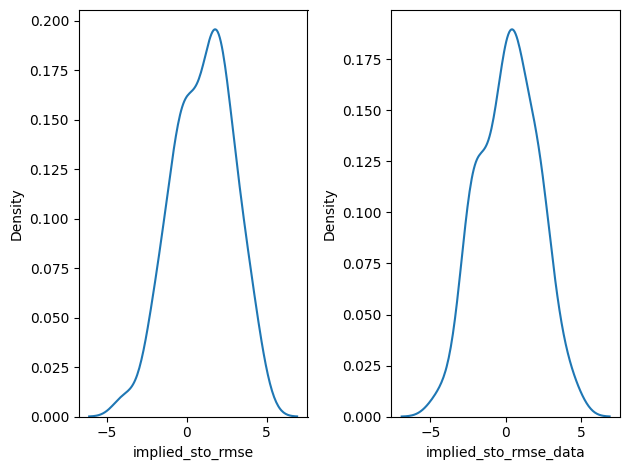

In [20]:
fig, axes = plt.subplots(ncols=2)
sns.kdeplot(x=np.log(df_result['implied_sto_rmse']), ax=axes[0])
sns.kdeplot(x=np.log(df_result['implied_sto_rmse_data']), ax=axes[1])
plt.tight_layout()
plt.show()

### Spatial relationship with main use?

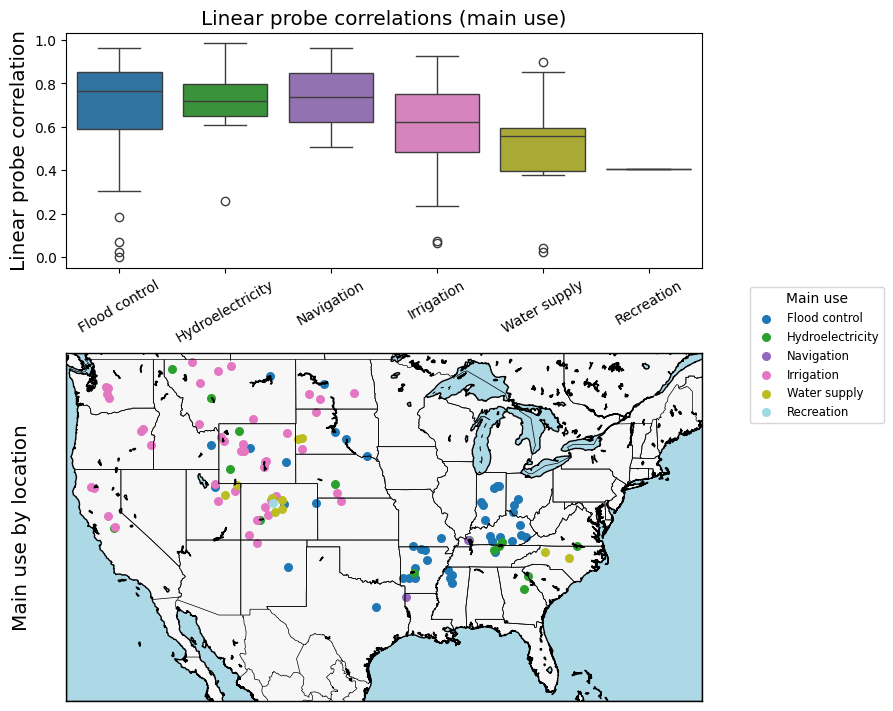

In [48]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 7), constrained_layout=True, gridspec_kw={'height_ratios': [1, 1.48]})
axes[0].set_box_aspect(0.37)
axes[0].set_ylabel("Linear probe correlation", size='x-large')

m = Basemap(projection='merc', llcrnrlat=24.396308, urcrnrlat=49.384358,
            llcrnrlon=-125.001650, urcrnrlon=-66.934570, resolution='i', ax=axes[1])
m.drawcoastlines(); m.drawcountries(); m.drawstates()
m.fillcontinents(color='#f7f7f7', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

cats = df_result['MAIN_USE']
unique = pd.Index(pd.unique(cats[-cats.isna()]))
cmap = plt.get_cmap('tab20', len(unique))

for i, cat in enumerate(unique):
    mask = (cats == cat)
    m.scatter(df_result.loc[mask, 'LONG'].values, df_result.loc[mask, 'LAT'].values,
              latlon=True, s=30, label=cat, color=cmap(i), ax=axes[1])
    
# Category specific linear_prob_corr boxplots
palette_list = [cmap(i) for i in range(len(unique))]
sns.boxplot(x='MAIN_USE', y='model1_linear_probe_corr', data=df_result, ax=axes[0], hue='MAIN_USE', order=unique, palette=palette_list, legend=False)
axes[0].tick_params(axis='x', labelrotation=30)
    
# Move legend outside the plot (right side)
fig.legend(title='Main use', bbox_to_anchor=(1, 0.5), loc='center right',
            borderaxespad=0., fontsize='small', title_fontsize='medium', ncol=1)

axes[0].set_title("Linear probe correlations (main use)", size='x-large')
axes[0].set_xlabel("")
axes[1].set_ylabel("Main use by location", size='x-large', labelpad=25)
plt.savefig('report/drafting/8_15_2025/Figures/cell_storage_corr_by_main_use.png', dpi=300)
plt.show()

In [49]:
df_result.groupby('MAIN_USE')['model1_linear_probe_corr'].describe()

,count,mean,std,min,25%,50%,75%,max
MAIN_USE,,,,,,,,
Flood control,43.0,0.681500,0.248662,0.000446,0.587887,0.766100,0.851074,0.961083
Hydroelectricity,15.0,0.707733,0.160254,0.258165,0.648979,0.719320,0.799065,0.984379
Irrigation,43.0,0.603941,0.206612,0.063666,0.482947,0.620077,0.749500,0.924799
Navigation,2.0,0.735743,0.322307,0.507838,0.621790,0.735743,0.849696,0.963649
Recreation,1.0,0.404843,NaN,0.404843,0.404843,0.404843,0.404843,0.404843
Water supply,10.0,0.494355,0.290004,0.024598,0.397703,0.558437,0.595086,0.898681


### Linear probe correlation vs. DOR vs. test R2 scatterplots

In [22]:
# Drop performance outliers
df_result = df_result.drop(index=['1249', '939', '597']) 

In [23]:
def lobf(x, y, ax):
    """Plot line of best fit"""
    #Find line of best fit
    a, b = np.polyfit(x, y, 1)
    #Add line of best fit to plot
    ax.plot(x, a*x+b, color='red')
    return

def correlate(x, y):
    """Return pearson correlation"""
    return stats.pearsonr(x, y)[0]

def correlate_pval(x, y, alt='two-sided', n_resamples=10000):
    """
    Return pval testing significance of correlation coefficient using permutation testing
    Params:
    x, y: data arrays to calculate correlation between
    alt: str, 'greater', 'less', or 'two-sided'. The alternative hypothesis
    n_resamples: int, number of permutations used to approximate null distribution
    Return:
    r - float, Pearson's correlation between x and y
    pvalue - p-value from permutation testing
    """
    # Calculate correlation between x and y and permuation test p-value
    res = stats.permutation_test((x, y), correlate, vectorized=False,
                        permutation_type='pairings',
                        alternative=alt,
                        n_resamples=n_resamples,
                        random_state=0)
    r, pvalue, null = res.statistic, res.pvalue, res.null_distribution
    return r, pvalue

c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples
c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples
c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


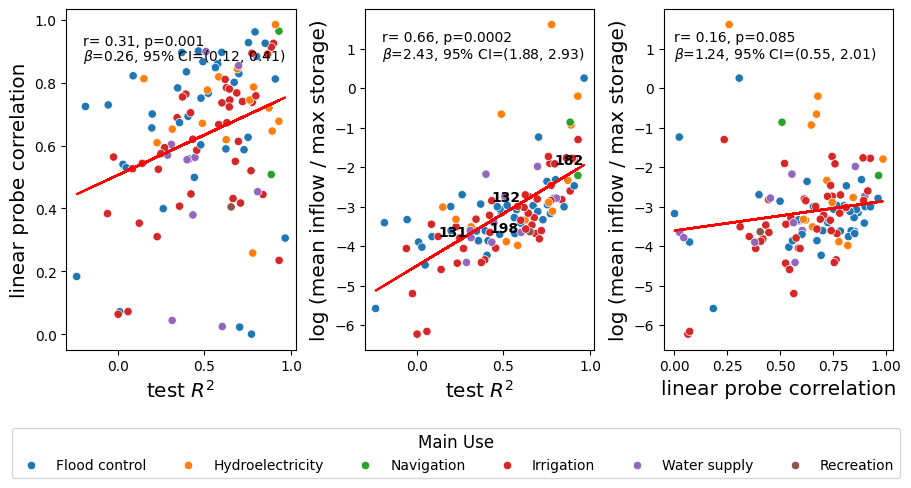

In [24]:
# Create scatter matrix of R2, max cell-storage correlation, and DOR (log mean in / max storage)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 4), constrained_layout=True)

vars = [df_result['model1_test_r2'], np.abs(df_result['model1_max_cell_sto_corr']), df_result['log_mean_in_max_sto'], df_result['model1_linear_probe_corr']]
var_names = ['test $R^2$', 'max cell-storage correlation', 'log (mean inflow / max storage)', 'linear probe correlation']

## R2 vs linear probe R2
sns.scatterplot(x=vars[0], y=vars[3], hue=df_result['MAIN_USE'], ax=axes[0])
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend_.remove()
axes[0].set_xlabel(var_names[0], size='x-large')
axes[0].set_ylabel(var_names[3], size='x-large')
lobf(vars[0], vars[3], axes[0])
# Add correlation and p-value
corr, pval = correlate_pval(vars[0], vars[3])
axes[0].text(-0.2, 0.92, r'r='+f' {round(corr, 2)}, p={round(pval, 6)}', size='medium')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(vars[3], vars[0], alpha=0.95)
axes[0].text(-0.2, 0.87, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='medium')

## R2 vs DOR
sns.scatterplot(x=vars[0], y=vars[2], hue=df_result['MAIN_USE'], ax=axes[1], legend=False)
axes[1].set_xlabel(var_names[0], size='x-large')
axes[1].set_ylabel(var_names[2], size='x-large')
lobf(vars[0], vars[2], axes[1])
# Add correlation and p-value
corr, pval = correlate_pval(vars[0], vars[2])
axes[1].text(-0.2, 1.2, r'r='+f' {round(corr, 2)}, p={round(pval, 6)}', size='medium')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(vars[2], vars[0], alpha=0.95)
axes[1].text(-0.2, 0.75, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='medium')
for id in ['132', '182', '198', '131']:
    axes[1].text(vars[0][id], vars[2][id], id, fontsize=10, weight='bold')

## Linear probe R2 vs DOR
sns.scatterplot(x=vars[3], y=vars[2], hue=df_result['MAIN_USE'], ax=axes[2], legend=False)
axes[2].set_xlabel(var_names[3], size='x-large')
axes[2].set_ylabel(var_names[2], size='x-large')
lobf(vars[3], vars[2], axes[2])
# Add correlation and p-value
corr, pval = correlate_pval(vars[3], vars[2])
axes[2].text(0, 1.2, r'r='+f' {round(corr, 2)}, p={round(pval, 4)}', size='medium')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(vars[2], vars[3], alpha=0.95)
axes[2].text(0, 0.75, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='medium')

legend = fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=6, frameon=True, title='Main Use', fontsize='medium', title_fontsize='large')
legend.set_in_layout(True)
plt.savefig('report/drafting/8_15_2025/Figures/r2_dor_cell_corr_main_use.png', dpi=300, bbox_inches='tight')
plt.show()

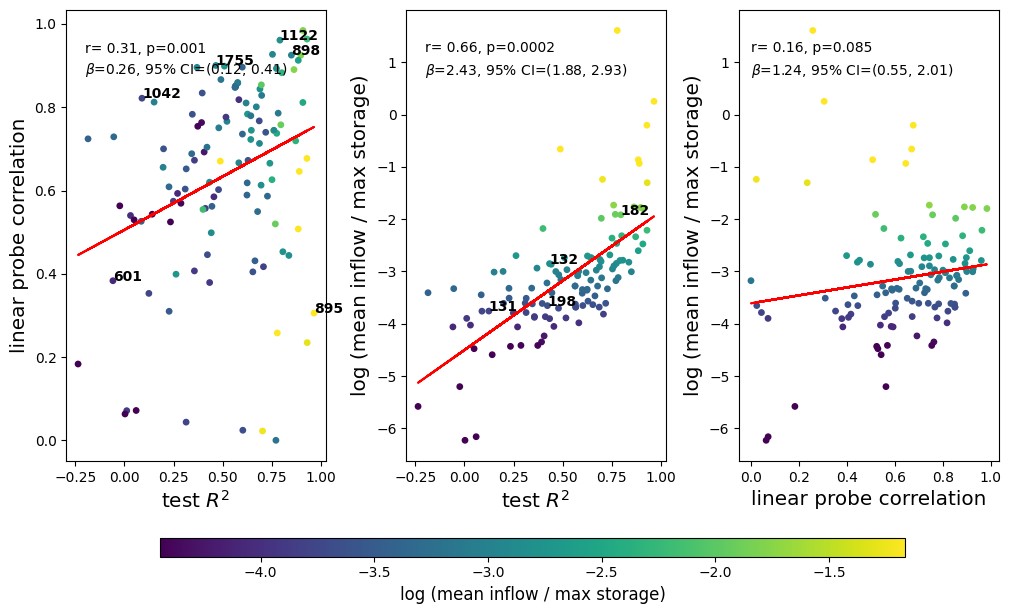

In [25]:
# Create scatter matrix of R2, max cell-storage correlation, and DOR (log mean in / max storage)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), constrained_layout=True)

vars = [df_result['model1_test_r2'], np.abs(df_result['model1_max_cell_sto_corr']), df_result['log_mean_in_max_sto'], df_result['model1_linear_probe_corr']]
var_names = ['test $R^2$', 'max cell-storage correlation', 'log (mean inflow / max storage)', 'linear probe correlation']

## R2 vs linear probe R2
norm = Normalize(vmin=np.percentile(vars[2], 5), vmax=np.percentile(vars[2], 95))
sc = axes[0].scatter(x=vars[0], y=vars[3], c=vars[2], s=15, cmap='viridis', norm=norm)
axes[0].set_xlabel(var_names[0], size='x-large')
axes[0].set_ylabel(var_names[3], size='x-large')
lobf(vars[0], vars[3], axes[0])
# Add correlation and p-value
corr, pval = correlate_pval(vars[0], vars[3])
axes[0].text(-0.2, 0.93, r'r='+f' {round(corr, 2)}, p={round(pval, 6)}', size='medium')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(vars[3], vars[0], alpha=0.95)
axes[0].text(-0.2, 0.88, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='medium')
for id in ['1042', '601', '898', '1122', '895', '1755']:
    axes[0].text(vars[0][id], vars[3][id], id, fontsize=10, weight='bold')

## R2 vs DOR
axes[1].scatter(x=vars[0], y=vars[2], c=vars[2], s=15, cmap='viridis', norm=norm)
axes[1].set_xlabel(var_names[0], size='x-large')
axes[1].set_ylabel(var_names[2], size='x-large')
lobf(vars[0], vars[2], axes[1])
# Add correlation and p-value
corr, pval = correlate_pval(vars[0], vars[2])
axes[1].text(-0.2, 1.2, r'r='+f' {round(corr, 2)}, p={round(pval, 6)}', size='medium')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(vars[2], vars[0], alpha=0.95)
axes[1].text(-0.2, 0.75, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='medium')
for id in ['132', '182', '198', '131']:
    axes[1].text(vars[0][id], vars[2][id], id, fontsize=10, weight='bold')

## Linear probe R2 vs DOR
axes[2].scatter(x=vars[3], y=vars[2], c=vars[2], s=15, cmap='viridis', norm=norm)
axes[2].set_xlabel(var_names[3], size='x-large')
axes[2].set_ylabel(var_names[2], size='x-large')
lobf(vars[3], vars[2], axes[2])
# Add correlation and p-value
corr, pval = correlate_pval(vars[3], vars[2])
axes[2].text(0, 1.2, r'r='+f' {round(corr, 2)}, p={round(pval, 4)}', size='medium')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(vars[2], vars[3], alpha=0.95)
axes[2].text(0, 0.75, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='medium')

# Add colorbar
cbar = fig.colorbar(sc, ax=[axes[0], axes[1], axes[2]], orientation='horizontal', pad=0.05, shrink=0.8, aspect=40)
cbar.set_label(var_names[2], size='large')
cbar.ax.tick_params(labelsize='medium')
plt.savefig('report/drafting/8_15_2025/Figures/r2_dor_cell_corr.png', dpi=300, bbox_inches='tight')
plt.show()

c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples
c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples
c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples
c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


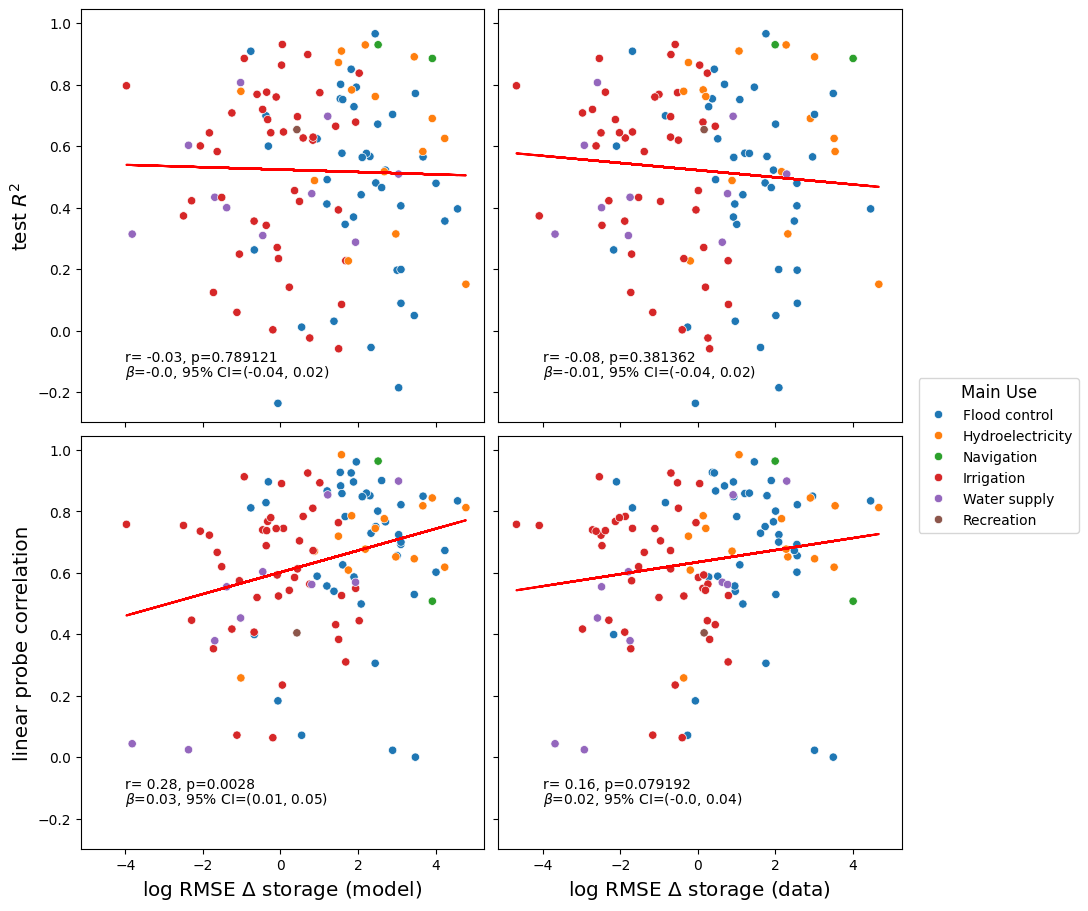

In [26]:
# Create scatter matrix of R2, max cell-storage correlation, and DOR (log mean in / max storage)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9), sharex=True, sharey=True, constrained_layout=True)

vars = [df_result['model1_test_r2'].values, df_result['model1_linear_probe_corr'], np.log(df_result['implied_sto_rmse']), np.log(df_result['implied_sto_rmse_data'])]
var_names = ['test $R^2$', 'linear probe correlation', r'log RMSE $\Delta$ storage (model)', r'log RMSE $\Delta$ storage (data)']

sns.scatterplot(x=vars[2], y=vars[0], hue=df_result['MAIN_USE'], ax=axes[0, 0])
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend_.remove()
axes[0, 0].set_ylabel(var_names[0], size='x-large')
lobf(vars[2], vars[0], axes[0, 0])
# Add correlation and p-value
corr, pval = correlate_pval(vars[0], vars[2])
axes[0, 0].text(-4, -0.1, r'r='+f' {round(corr, 2)}, p={round(pval, 6)}', size='medium')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(vars[0], vars[2], alpha=0.95)
axes[0, 0].text(-4, -0.15, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='medium')


sns.scatterplot(x=vars[3], y=vars[0], hue=df_result['MAIN_USE'], ax=axes[0, 1], legend=False)
lobf(vars[3], vars[0], axes[0, 1])
# Add correlation and p-value
corr, pval = correlate_pval(vars[0], vars[3])
axes[0, 1].text(-4, -0.1, r'r='+f' {round(corr, 2)}, p={round(pval, 6)}', size='medium')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(vars[0], vars[3], alpha=0.95)
axes[0, 1].text(-4, -0.15, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='medium')

sns.scatterplot(x=vars[2], y=vars[1], hue=df_result['MAIN_USE'], ax=axes[1, 0], legend=False)
axes[1, 0].set_ylabel(var_names[1], size='x-large')
axes[1, 0].set_xlabel(var_names[2], size='x-large')
lobf(vars[2], vars[1], axes[1, 0])
# Add correlation and p-value
corr, pval = correlate_pval(vars[2], vars[1])
axes[1, 0].text(-4, -0.1, r'r='+f' {round(corr, 2)}, p={round(pval, 6)}', size='medium')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(vars[1], vars[2], alpha=0.95)
axes[1, 0].text(-4, -0.15, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='medium')

sns.scatterplot(x=vars[3], y=vars[1], hue=df_result['MAIN_USE'], ax=axes[1, 1], legend=False)
axes[1, 1].set_xlabel(var_names[3], size='x-large')
lobf(vars[3], vars[1], axes[1, 1])
# Add correlation and p-value
corr, pval = correlate_pval(vars[3], vars[1])
axes[1, 1].text(-4, -0.1, r'r='+f' {round(corr, 2)}, p={round(pval, 6)}', size='medium')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(vars[1], vars[3], alpha=0.95)
axes[1, 1].text(-4, -0.15, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='medium')

legend = fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1, frameon=True, title='Main Use', fontsize='medium', title_fontsize='large')
legend.set_in_layout(True)
plt.show()

### Plot cell-state (linear probe) vs. storage timeseries

In [27]:
def plot_probe_storage(id, model, left_year, ax, return_data=False):
    """ 
    For a given reservoir ID, plot linear probe predictions vs. observed storage.
    Params:
    id - str, ResOPS/USBR id to plot for
    model - LSTM model to evaluate cell states from
    left_year - left year window for data processing, i.e. from get_left_years(res_list)[res_id]
    ax - matplotlib axes to plot on
    """
    df_corr, data = correlate_cell_storage(id=id, model=model, left_year=left_year, return_data=True)
    storage_test = data['df_splits'][2].storage.values
    ax.plot((storage_test - storage_test.mean()) / storage_test.std()) # plot standardized observed storage (test data)

    probe = cell_linear_probe()
    probe.fit_probe(cell_states=data['cell_splits'][0][0], storage_state=data['df_splits'][0].storage.values) # fit probe on training data
    probe_pred_test = probe.predict(data['cell_splits'][2][0])[:len(data['df_splits'][2])] # probe predictions on test data
    ax.plot((probe_pred_test - probe_pred_test.mean()) / probe_pred_test.std()) # standardize probe predictions and plot

    ax.legend(['observed storage', rf'linear probe (r={round(df_corr.loc["linear_probe", "test"], 2)})'], loc='upper left')

    if return_data:
        return df_corr, data

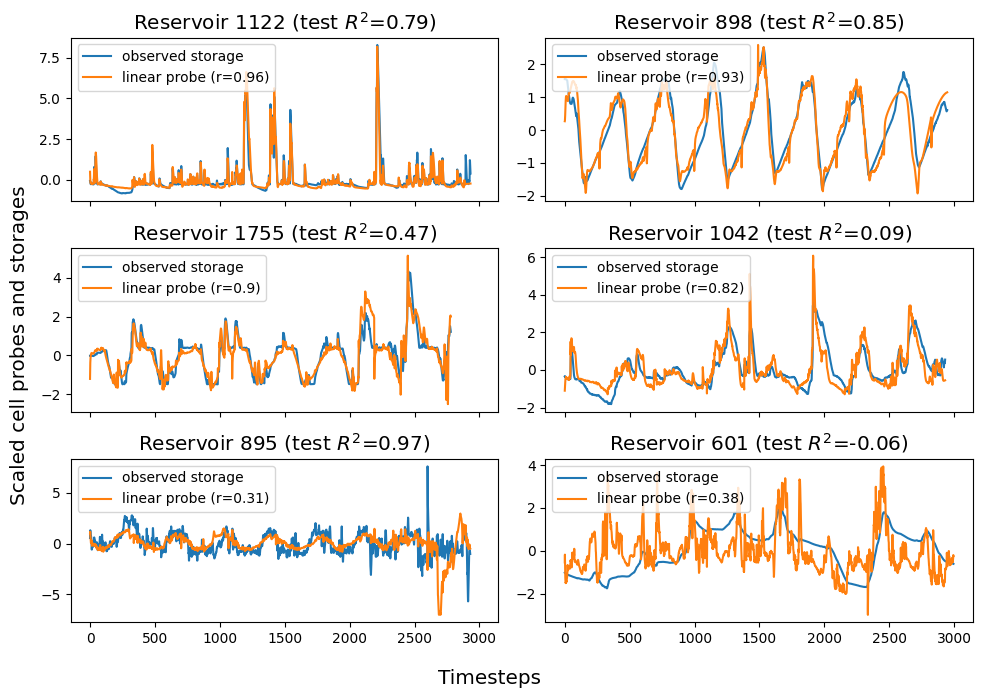

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7), sharex=True)

left_years_dict = get_left_years(res_list=filter_res())
for ax, res in zip(axes.flatten(), ['1122', '898', '1755', '1042', '895', '601']):
    plot_probe_storage(id=res, model=load_resops_model(res_id=res, model_num=1), left_year=left_years_dict[res], ax=ax)
    ax.set_title(f'Reservoir {res} (test $R^2$={round(df_result.loc[res, 'model1_test_r2'], 2)})', size='x-large')

fig.supxlabel("Timesteps", size='x-large')
fig.supylabel("Scaled cell probes and storages", size='x-large')
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/cell_probe_storage_plots.png', dpi=300)
plt.show()

In [29]:
df_result.loc[['1122', '898', '1042', '895', '1755', '601'], :]

,mean_inflow,max_storage,model1_test_r2,outflow_storage_corr,inflow_storage_corr,implied_sto_rmse,implied_sto_rmse_data,log_mean_in_max_sto,log_mean_in_max_sto_cat,model1_linear_probe_corr,LONG,LAT,model1_max_cell_sto_corr,model2_max_cell_sto_corr,MAIN_USE
1122,14.919751,243.386,0.792157,0.633382,0.405052,7.071329,4.289669,-2.791963,medium,0.961083,-94.228715,34.211828,0.930453,0.943109,Flood control
898,45.242435,914.580,0.850579,0.363919,0.627546,6.193909,1.528339,-3.006429,medium,0.925089,-104.953299,42.480230,0.813007,0.893787,Flood control
1042,58.201374,2501.491,0.089033,0.452292,0.197279,22.364848,12.986096,-3.760733,high,0.821699,-92.238377,36.252069,0.762670,0.771842,Flood control
895,776.380000,603.172,0.965952,-0.116951,-0.097066,11.501902,5.784825,0.252440,low,0.305771,-97.483244,42.850337,0.306073,0.406567,Flood control
1755,41.794670,841.633,0.465441,0.071091,0.078141,13.596184,6.633284,-3.002575,medium,0.900339,-86.122475,36.893486,0.471568,0.914325,Flood control
601,35.697140,2073.037,-0.058900,0.378451,0.292956,4.486278,1.355110,-4.061699,very_high,0.383538,-107.609481,36.801492,0.361836,0.372292,Irrigation
